In [1]:
import os


from optuna.logging import set_verbosity, WARNING
os.system('cls' if os.name == 'nt' else 'clear')
import json
import joblib
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn as F
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import List, Tuple
from torch.amp import autocast, GradScaler

from tqdm.auto import tqdm
from optuna.logging import set_verbosity, CRITICAL
import sys
from sklearn.metrics import f1_score, roc_auc_score


In [2]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
optuna.seed = seed

os.environ["OMP_NUM_THREADS"] = "1"    # limit OpenMP threads
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"


In [3]:
# --- Step 1: Load the Data ---
X = pd.read_csv("x_df.csv", parse_dates=['admittime', 'dischtime'])
y = pd.read_csv("y_df.csv")






In [4]:
def preprocess_data(
    x_df: pd.DataFrame,
    y_df: pd.DataFrame,
    sequence_length: int,
    exclude_columns: List[str]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepares padded sequential data for LSTM input from admission records.

    Args:
        x_df (pd.DataFrame): Feature dataframe containing 'subject_id' and 'admittime'.
        y_df (pd.DataFrame): Label dataframe (should align with x_df).
        sequence_length (int): Max number of admissions in a sequence.
        exclude_columns (List[str]): Columns to exclude from features.

    Returns:
        Tuple:
            sequences (np.ndarray): Array of shape (samples, sequence_length, num_features).
            labels (np.ndarray): Labels for each sequence.
            lengths (np.ndarray): Actual length of each sequence before padding.
            groups (np.ndarray): Patient ID (subject_id) for each sequence.
    """
    y_df = y_df.astype(int)
    x_df = x_df.copy()
    y_df["label"] = x_df["label"]   # Ensure label is merged

    sequences = []
    labels = []
    lengths = []
    groups = []

    for subject_id, group in x_df.groupby("subject_id"):
        group = group.sort_values("admittime")

        features = group.drop(columns=exclude_columns).values
        targets = group["label"].values
        num_admissions = len(group)

        if num_admissions >= 1:
            for i in range(1, num_admissions):
                start_idx = max(0, i - sequence_length)
                seq = features[start_idx:i]

                true_len = len(seq)

                # Pad sequence if needed
                if true_len < sequence_length:
                    padding = np.zeros((sequence_length - true_len, seq.shape[1]))
                    seq = np.vstack((padding, seq))

                sequences.append(seq)
                labels.append(targets[i])
                lengths.append(true_len)
                groups.append(subject_id)

    return (
        np.array(sequences),
        np.array(labels),
        np.array(lengths),
        np.array(groups)
    )

#(X, y, lengths,groups) =  preprocess_data(x_df, y_df,sequence_length,exclude_columns)

In [5]:
def prepare_data(x__df: pd.DataFrame,y__df: pd.DataFrame,sequence_length=9 ):
    x_df = x__df.copy()
    y_df = y__df.copy()

    y_df = y_df.astype(int)
    bool_cols = x_df.select_dtypes(include='bool').columns
    x_df[bool_cols] = x_df[bool_cols].astype(int)

    # Merge labels with features
    x_df['label'] = y_df['label']

    # --- Step 2: Sort by patient and admission time ---
    x_df=x_df.sort_values(by=['subject_id', 'admittime'])

    # --- Step 3: Set parameters ---

    exclude_columns = ['subject_id', 'admittime', 'dischtime', 'label']

    # --- Step 4: Create sequences ---
    sequences = []
    labels = []

    exclude_columns = ['subject_id', 'admittime', 'dischtime', 'label']

    (X, y, lengths,groups)=preprocess_data(x_df, y_df, sequence_length, exclude_columns)
    return X, y, lengths, groups


In [6]:
def oversampling(X,y,sequence_length=9):
    X_copy = X.copy()



    exclude_columns = ['subject_id', 'admittime', 'dischtime']
    features_to_use = [c for c in X_copy.columns if c not in exclude_columns]

    X_copy_for_smote = X_copy[features_to_use]
    y_copy_for_smote = y.copy()

    if isinstance(X_copy, pd.DataFrame):
        X_copy = X_copy.replace([np.inf, -np.inf], np.nan).dropna()
        y_copy_for_smote = y_copy_for_smote.loc[X_copy.index]

    # Dynamically pick safe k_neighbors

    counts = Counter(y_copy_for_smote)
    min_class_size = min(counts.values())
    k_neighbors = max(1, min(5, min_class_size - 1))

    enc = SMOTE(k_neighbors=k_neighbors,random_state=42)
    X_resampled, y_resampled = enc.fit_resample(X_copy_for_smote, y_copy_for_smote)

    n_real = len(X_copy_for_smote)
    n_total = len(X_resampled)
    n_synth = n_total - n_real

    # Extract only the synthetic rows
    X_synth = X_resampled[n_real:]
    y_synth = y_resampled[n_real:]

    X_synth_df = pd.DataFrame(X_synth, columns=features_to_use)
    y_synth_df = pd.DataFrame(y_synth, columns=['label'])

    # Assign fake metadata
    X_synth_df["subject_id"] = np.random.randint(100000, 999999, size=len(X_synth_df))
    X_synth_df["admittime"] = pd.to_datetime("2020-01-01") + pd.to_timedelta(
            np.random.randint(0, 1000, size=len(X_synth_df)), unit='h')
    X_synth_df["dischtime"] = X_synth_df["admittime"] + pd.to_timedelta(4, unit='h')


    X_train_extended = pd.concat([X, X_synth_df], ignore_index=True)
    y_train_extended = pd.concat([y, y_synth_df], ignore_index=True)

    (X_train,y_train,len_train,group_train) = prepare_data(X_train_extended, y_train_extended,sequence_length)


    return X_train, y_train, len_train, group_train

In [7]:
class ReadmissionDataset(torch.utils.data.Dataset):
    def __init__(self, X, y,lengths):
        self.X = torch.tensor(X, dtype=torch.float32)  # shape: (N, T, F)
        self.y = torch.tensor(y, dtype=torch.long)     # long for classification
        self.lengths = torch.tensor(lengths, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_seq = self.X[idx]
        y_val = self.y[idx]
        length = self.lengths[idx]
        return x_seq, length, x_seq, y_val  # return twice for LSTM and CNN input

In [8]:
X_train_all, X_test_, y_train_all, y_test_ = train_test_split(X,y,
    test_size=0.2,
    random_state=42,
    stratify=y  # optional: preserves label ratio
)

In [9]:
sequence_length = 9
(X_test, y_test, lengths_test, group_test) = prepare_data(X_test_, y_test_, sequence_length)
print(X_test.shape)
test_data = ReadmissionDataset(X_test, y_test, lengths_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)
num_features = X_test.shape[2]

(21, 9, 41)


In [10]:
class LSTMStack(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMStack, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

    def forward(self, x,lengths):
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        output, (hn, cn) = self.lstm(packed)
        return hn[-1]  # (batch_size, hidden_size)  <-- 2D

class CNNExtractor(nn.Module):
    def __init__(self, input_size, cnn_channels, kernel_size, dropout):
        super(CNNExtractor, self).__init__()
        self.input_size = input_size
        self.cnn_channels = cnn_channels
        padding = kernel_size // 2
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, cnn_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),

            nn.Conv1d(cnn_channels, cnn_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),

            nn.Dropout(dropout)
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # x expected as (B, S, F); Conv1d wants (B, F, S)
        x = x.permute(0, 2, 1)              # (B, F, S)
        x = self.cnn(x)                     # (B, C, S)
        # Collapse the time dimension so we return 2D features
        x = self.global_pool(x)
        x = x.squeeze(-1)

        return x  # (batch_size, cnn_channels)  <-- 2D

class DiagnosisModel(nn.Module):
    def __init__(self, input_size, hidden_size, cnn_channels, kernel_size, num_layers, dropout):
        super(DiagnosisModel, self).__init__()
        self.lstm = LSTMStack(input_size, hidden_size, num_layers)
        self.cnn = CNNExtractor(input_size, cnn_channels, kernel_size, dropout)

        in_features = hidden_size + cnn_channels  # match what we actually concatenate
        self.mlp = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # 2 classe
        )

    def forward(self, lstm_input,lengths, cnn_input):
        lstm_features = self.lstm(lstm_input,lengths)   # (B, hidden_size)
        cnn_features = self.cnn(cnn_input)      # (B, cnn_channels)

        # Both branches are 2D now, so concatenation works
        combined = torch.cat([lstm_features, cnn_features], dim=1)  # (B, hidden_size + cnn_channels)
        return self.mlp(combined)  # (batch_size, 2)


In [11]:
def train(model, dataloader, optimizer, criterion, device,epochs):
    castauto=False
    model.train()
    histroy = []
    for i in range(epochs):
        epoch_loss = 0.0
        for X_batch,length_batch,lstm_batch, y_batch in tqdm(dataloader, desc=f"Epoch {i+1}/{epochs}", leave=False,ncols=80):
            lstm_batch = lstm_batch.to(device)

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            if length_batch.dim() > 1:
                    length_batch = length_batch.squeeze(-1)
            length_batch = length_batch.to(torch.int64)
            preds = model(lstm_batch,length_batch,X_batch)
            loss = criterion(preds, y_batch.long())
            loss.backward()
            optimizer.step()


            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        histroy.append(avg_loss)
        print(f"Epoch {epochs + 1}/{epochs} - Loss: {avg_loss:.4f}")
    return model,histroy


In [12]:
def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_pos_scores = []
    with torch.no_grad():
        for X_batch,length_batch,lstm_batch, y_batch in  dataloader:
            lstm_batch = lstm_batch.to(device)
            X_batch = X_batch.to(device)
            if length_batch.dim() > 1:
                length_batch = length_batch.squeeze(-1)
            length_batch = length_batch.to(torch.int64)
            logits = model(lstm_batch,length_batch, X_batch)              # (B, 2), raw logits
            probs_pos = torch.softmax(logits, dim=1)[:, 1]          # (B,), P(class=1
            all_pos_scores.append(probs_pos.detach().cpu())
            all_labels.append(y_batch.detach().cpu())


        if len(all_labels) == 0 or len(all_pos_scores) == 0:
            print("⚠️ Validation produced no batches. Returning score = 0.0")
            return 0.0

    y_true = torch.cat(all_labels,dim=0).numpy()                      # shape (N,)
    y_score = torch.cat(all_pos_scores,dim=0).numpy()

    return model,y_true,y_score

In [13]:
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import contextlib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import gc
@contextlib.contextmanager
def suppress_output():
    """Temporarily suppress all stdout and stderr."""
    with open(os.devnull, 'w') as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr


# ------------------------------
# Optuna Objective Function
# ------------------------------

subject_ids = X_train_all['subject_id']
scaler = GradScaler("cuda")
def objective(trial):
    import torch
    import torch.nn as nn


    torch.backends.cudnn.benchmark = True
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    sequence_length = trial.suggest_int("seq_len", 3, 15)


    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    kernel_size = trial.suggest_int("kernel_size", 1, 3)
    cnn_channels = trial.suggest_int("cnn_channels", 16, 64)

    input_size= num_features
    model = DiagnosisModel(input_size=input_size, hidden_size=hidden_dim,cnn_channels=cnn_channels,kernel_size=kernel_size ,num_layers=num_layers,dropout=dropout)

    #print(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    #criterion = nn.CrossEntropyLoss()

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    aucs = []

    for fold,(train_index, val_index) in enumerate(skf.split(X_train_all, y_train_all,groups=subject_ids)):

        X_train_, X_val = X_train_all.iloc[train_index], X_train_all.iloc[val_index]
        y_train_, y_val = y_train_all.iloc[train_index], y_train_all.iloc[val_index]


        if optimizer_name == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = (torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9))



        (X_train, y_train, len_train, group_train) = oversampling(X_train_,y_train_,sequence_length)
        (X_val,y_val,len_val,group_val) = prepare_data(X_val, y_val,sequence_length)

        # 📊 Class distribution AFTER oversampling
        new_counts = Counter(y_train)
        print("  After oversampling:")
        for cls, count in new_counts.items():
            print(f"  Class {cls}: {count} samples")

        if X_val.shape[0] == 0 or X_train.shape[0] == 0:
            print(f"⚠️ Skipping fold {fold} due to empty train or val set.")
            continue

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

        train_data = ReadmissionDataset(X_train, y_train,len_train)
        val_data = ReadmissionDataset(X_val, y_val,len_val)

        train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        (model,loss) = train(model, train_loader, optimizer, criterion, device,epochs=5)

        # Evaluate
        (model,y_true,y_score)= evaluate(model, val_loader, device)


        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y_true, y_score)                        # binary ROC AUC
        aucs.append(auc)

        # --------------------------
        # Final AUC Score
        # --------------------------
        if len(aucs) == 0:
            return 0.0  # all folds failed

        # Cleanup
        #del train_loader, val_loader
        #torch.cuda.empty_cache()
        #gc.collect()

    mean_auc = float(np.mean(aucs))
    return mean_auc



In [ ]:
# Ensure output folder exists
os.makedirs("model", exist_ok=True)

# Silence Optuna's logs, but keep tqdm bar
set_verbosity(CRITICAL)
optuna.logging.disable_default_handler()

print("🔍 Starting Optuna optimization with progress bar...\n")

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    load_if_exists=True
)

study.optimize(
    objective,
    n_trials=100,
    n_jobs=8,
    show_progress_bar=True  # 👈 tqdm-style global progress bar
)

print("\n✅ Optimization complete!")

# Save and report best result
joblib.dump(study, "model/optuna_study.pkl")
with open("model/best_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=2)

print("\n🏆 Best trial:")
print(study.best_trial)


🔍 Starting Optuna optimization with progress bar...



  0%|          | 0/100 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 211 samples
  Class 1: 53 samples
  After oversampling:
  Class 0: 211 samples
  Class 1: 54 samples
  After oversampling:
  Class 0: 211 samples
  Class 1: 58 samples
  After oversampling:
  Class 0: 211 samples
  Class 1: 54 samples
  After oversampling:
  Class 0: 211 samples
  Class 1: 53 samples
  After oversampling:
  Class 0: 211 samples
  Class 1: 55 samples
  After oversampling:
  Class 0: 211 samples
  Class 1: 56 samples
  After oversampling:
  Class 0: 211 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7185


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6963


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6947


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6946


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6950


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6880


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6968


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6817


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6848


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7274
Epoch 6/5 - Loss: 0.6759


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6596
Epoch 6/5 - Loss: 0.6983
Epoch 6/5 - Loss: 0.7116
Epoch 6/5 - Loss: 0.7063
Epoch 6/5 - Loss: 0.7086
Epoch 6/5 - Loss: 0.6938


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6525
Epoch 6/5 - Loss: 0.6442


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6945


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6868
Epoch 6/5 - Loss: 0.6960
Epoch 6/5 - Loss: 0.6946
Epoch 6/5 - Loss: 0.6971


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 207 samples
  Class 1: 55 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7096
Epoch 6/5 - Loss: 0.6128


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 207 samples
  Class 1: 55 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6847


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7092


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7069


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6906
Epoch 6/5 - Loss: 0.6816
Epoch 6/5 - Loss: 0.7066
Epoch 6/5 - Loss: 0.6816
Epoch 6/5 - Loss: 0.6592
Epoch 6/5 - Loss: 0.6961


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6911


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 207 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6498
Epoch 6/5 - Loss: 0.7153
Epoch 6/5 - Loss: 0.6457


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6861
Epoch 6/5 - Loss: 0.6850
  After oversampling:
  Class 0: 207 samples
  Class 1: 62 samples


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6959
Epoch 6/5 - Loss: 0.6569


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6972


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5837


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6638
Epoch 6/5 - Loss: 0.7097


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6821
  After oversampling:
  Class 0: 207 samples
  Class 1: 59 samples
Epoch 6/5 - Loss: 0.5814


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7061


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6638
  After oversampling:
  Class 0: 207 samples
  Class 1: 56 samples
Epoch 6/5 - Loss: 0.7067


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5929
Epoch 6/5 - Loss: 0.6749


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 207 samples
  Class 1: 57 samples
Epoch 6/5 - Loss: 0.6949


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6929


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 207 samples
  Class 1: 59 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5476
Epoch 6/5 - Loss: 0.6898


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4954
Epoch 6/5 - Loss: 0.6483


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7240


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6718


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6979


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 206 samples
  Class 1: 60 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6882
Epoch 6/5 - Loss: 0.7107


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4420
Epoch 6/5 - Loss: 0.5875


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 206 samples
  Class 1: 52 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5110


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6841


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6512


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6847
Epoch 6/5 - Loss: 0.6997


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6588


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4617
Epoch 6/5 - Loss: 0.6930


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6449


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

  After oversampling:
  Class 0: 206 samples
  Class 1: 54 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6840
Epoch 6/5 - Loss: 0.6863
  After oversampling:
  Class 0: 206 samples
  Class 1: 56 samples
Epoch 6/5 - Loss: 0.6068


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6980
  After oversampling:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6068


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6654


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6769


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.7546
Epoch 6/5 - Loss: 0.7160
Epoch 6/5 - Loss: 0.6804


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5824


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6135
  After oversampling:
  Class 0: 206 samples
  Class 1: 55 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6796


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.4481


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.5448


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6744


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6823
Epoch 6/5 - Loss: 0.5688
Epoch 6/5 - Loss: 0.4336


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.6793
Epoch 6/5 - Loss: 0.7156
Epoch 6/5 - Loss: 0.5679


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

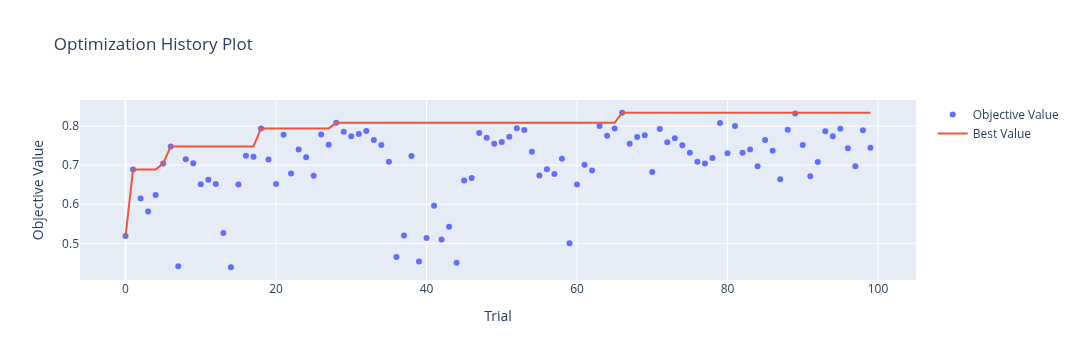

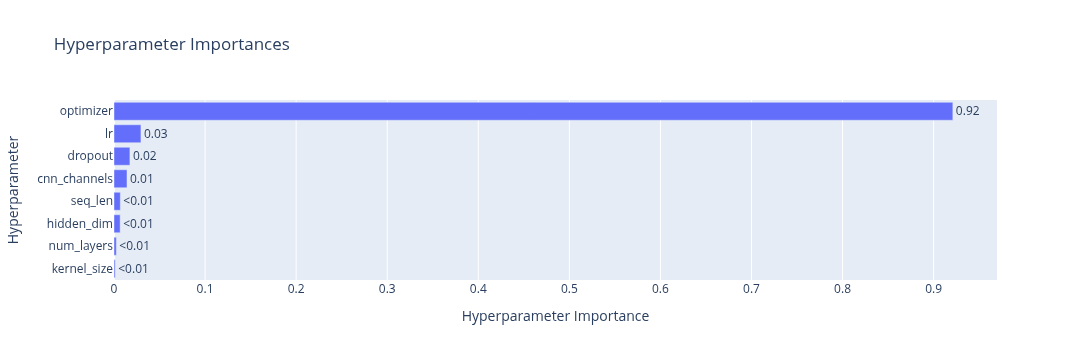

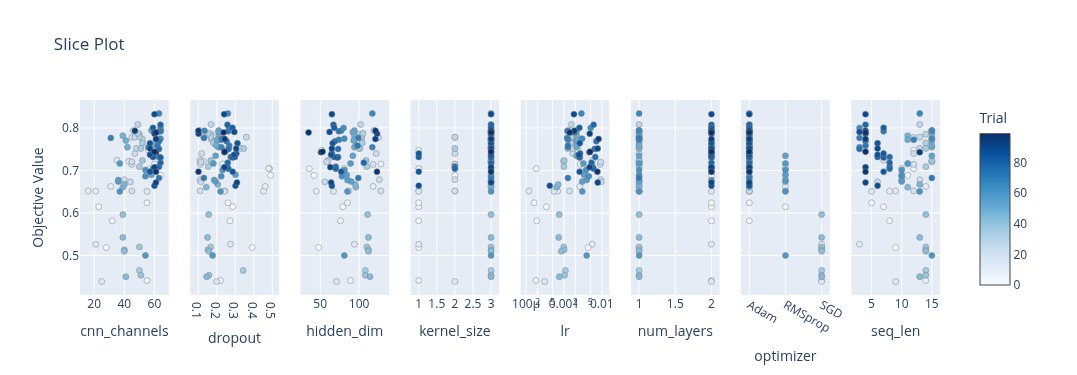

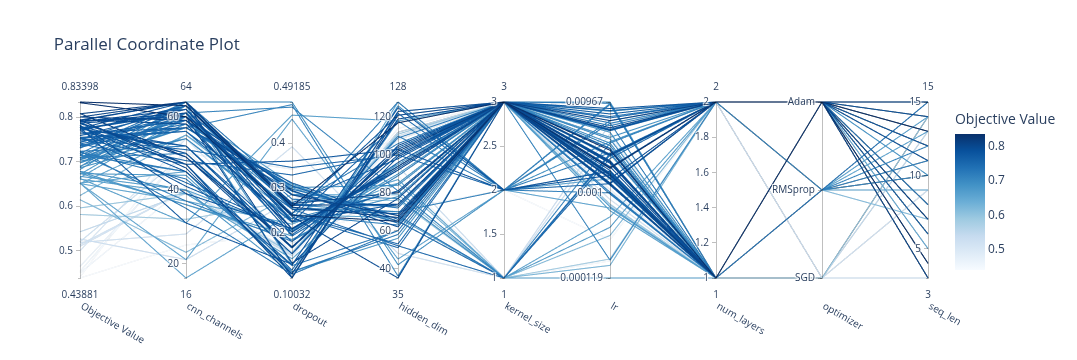

In [15]:
import optuna.visualization as vis

# Requires: pip install optuna[visualization]
try:
    fig1 = vis.plot_optimization_history(study)
    fig1.show()

    fig2 = vis.plot_param_importances(study)
    fig2.show()

    fig3 = vis.plot_slice(study)
    fig3.show()

    fig4 = vis.plot_parallel_coordinate(study)
    fig4.show()

except Exception as e:
    print("Visualization requires an interactive environment like Jupyter.")
    print(e)

In [16]:
def build_model(params):
    model = DiagnosisModel(
            input_size=num_features,
            cnn_channels=params["cnn_channels"],
            kernel_size=params["kernel_size"],
            hidden_size=params["hidden_dim"],
            num_layers=params["num_layers"],
            dropout=params["dropout"]
        )
    return model

In [17]:
best_params = study.best_trial.params
print("Best parameters:", best_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = build_model(best_params).to(device)
torch.save(model.state_dict(), "model/best_model.pt")

Best parameters: {'hidden_dim': 81, 'num_layers': 1, 'dropout': 0.13421038399110438, 'lr': 0.0005396329307348579, 'seq_len': 6, 'optimizer': 'RMSprop', 'kernel_size': 3, 'cnn_channels': 34}


In [18]:
sequence_length = best_params["seq_len"]
print(sequence_length)

sequence_length = best_params["seq_len"]


6


In [39]:
lr=best_params["lr"]

optimizer_name = best_params["optimizer"]
#criterion = nn.CrossEntropyLoss()

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
elif optimizer_name == "SGD":
    optimizer = (torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9))



thresholds = np.linspace(0, 1, 101)


f1scores =[] 
all_folds_labels=[]
all_folds_scores=[]
aucs = []
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []
losses =[]
for fold,(train_index, val_index) in enumerate(skf.split(X_train_all, y_train_all,groups=subject_ids)):
    X_train_, X_val = X_train_all.iloc[train_index], X_train_all.iloc[val_index]
    y_train_, y_val = y_train_all.iloc[train_index], y_train_all.iloc[val_index]


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)



    (X_train, y_train, len_train, group_train) = oversampling(X_train_,y_train_)
    (X_val,y_val,len_val,group_val) = prepare_data(X_val, y_val)

    # 📊 Class distribution AFTER oversampling
    new_counts = Counter(y_train)
    print("  After oversampling:")
    for cls, count in new_counts.items():
        print(f"  Class {cls}: {count} samples")

    if X_val.shape[0] == 0 or X_train.shape[0] == 0:
        print(f"⚠️ Skipping fold {fold} due to empty train or val set.")
        continue

    # --------------------------
        # Compute and apply class weights
        # --------------------------
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)


    train_data = ReadmissionDataset(X_train, y_train,len_train)
    val_data = ReadmissionDataset(X_val, y_val,len_val)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=True, pin_memory=True)


    (model,loss) = train(model, train_loader, optimizer, criterion, device,epochs=5)# short training for optimization


 # Evaluate

    (model,y_true,y_score) =evaluate(model, val_loader, device)
    all_folds_labels.append(y_true)
    all_folds_scores.append(y_score)

    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_true, y_score)                        # binary ROC AUC
    aucs.append(auc)
    losses.append(loss)

    f1_scores = [f1_score(y_true, y_score >= t) for t in thresholds]

    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    f1scores.append(best_f1)
    print(f"Best F1 threshold = {best_thresh:.3f}, F1 = {best_f1:.4f}")
    # Cleanup
    del train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()




mean_auc = float(np.mean(aucs))
print(f"Mean 5-fold ROC-AUC: {mean_auc:.4f}")

  After oversampling:
  Class 0: 211 samples
  Class 1: 56 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0807


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0774


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0196


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0252


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0255
Best F1 threshold = 0.470, F1 = 1.0000
  After oversampling:
  Class 0: 207 samples
  Class 1: 58 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1287


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.1923


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0889


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0664


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0635
Best F1 threshold = 0.130, F1 = 1.0000
  After oversampling:
  Class 0: 206 samples
  Class 1: 53 samples


Epoch 1/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.3380


Epoch 2/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0287


Epoch 3/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0198


Epoch 4/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0433


Epoch 5/5:   0%|                                          | 0/5 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0135
Best F1 threshold = 0.790, F1 = 1.0000
  After oversampling:
  Class 0: 202 samples
  Class 1: 54 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0833


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0446


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0205


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0202


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0101
Best F1 threshold = 0.090, F1 = 1.0000
  After oversampling:
  Class 0: 202 samples
  Class 1: 43 samples


Epoch 1/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0407


Epoch 2/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0149


Epoch 3/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0122


Epoch 4/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0094


Epoch 5/5:   0%|                                          | 0/4 [00:00<?, ?it/s]

Epoch 6/5 - Loss: 0.0094
Best F1 threshold = 0.040, F1 = 1.0000
Mean 5-fold ROC-AUC: 1.0000


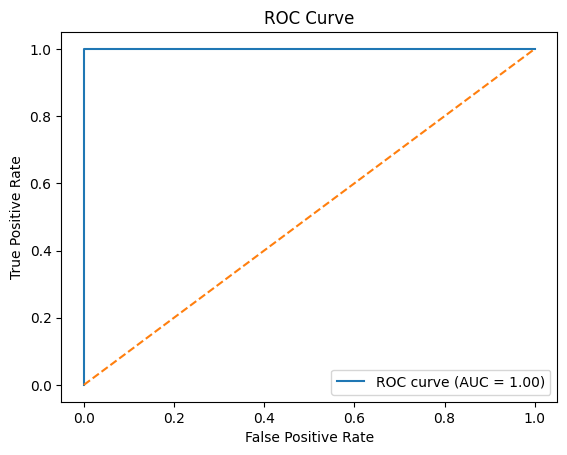

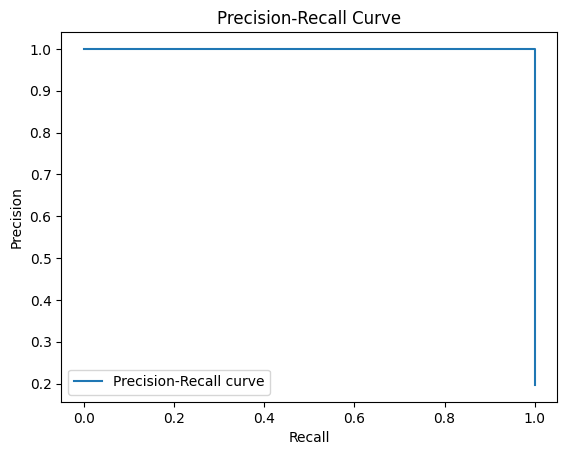

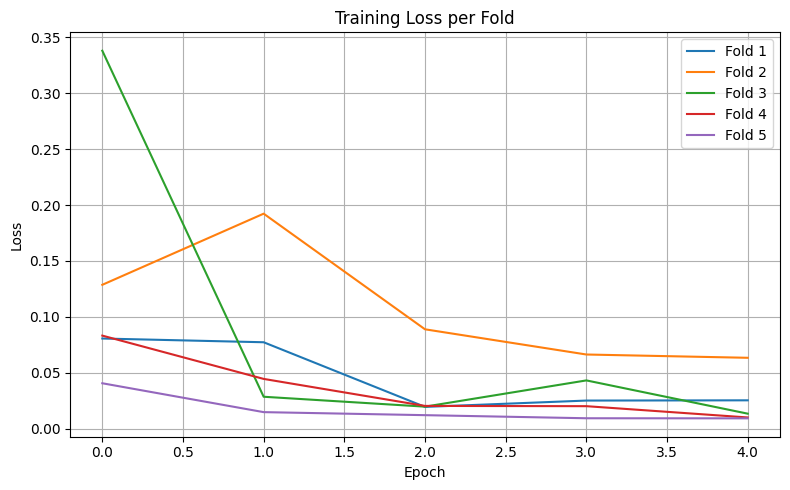

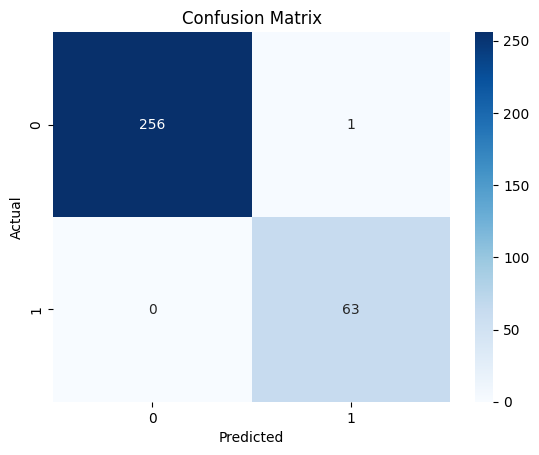


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       257
           1       0.98      1.00      0.99        63

    accuracy                           1.00       320
   macro avg       0.99      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all folds
y_true_all = np.concatenate(all_folds_labels)
y_score_all = np.concatenate(all_folds_scores)
y_pred_all = (y_score_all > 0.5).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_score_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_all, y_score_all)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot training loss per fold
plt.figure(figsize=(8, 5))
for i, loss_history in enumerate(losses):
    plt.plot(loss_history, label=f"Fold {i+1}")
plt.title("Training Loss per Fold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_all, y_pred_all))

In [41]:
(X_test, y_test, lengths_test, group_test) = prepare_data(X_test_, y_test_, sequence_length)
print(X_test.shape)
test_data = ReadmissionDataset(X_test, y_test, lengths_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

(model,y_true,y_score)=evaluate(model, test_loader, device)
print("Test ROC AUC:", roc_auc_score(y_true, y_score))

(21, 6, 41)
Test ROC AUC: 0.5


In [ ]:
def best_f1_threshold(y_true_list, y_score_list,plot):
      """
        Find the threshold that maximizes F1-score.
        
        Parameters:
            y_true  : array-like, true binary labels
            y_score : array-like, predicted probabilities for positive class
            plot    : bool, if True plots F1 vs threshold
            
        Returns:
            best_thresh (float): threshold that gives best F1
            best_thresh (float): threshold that gives best F1
            best_f1 (float): best F1-score value
    """
    y_true = np.concatenate(y_true_list)
    y_score = np.concatenate(y_score_list)
    thresholds = np.linspace(0, 1, 101)
    f1s = [f1_score(y_true, y_score >= t) for t in thresholds]
    best_t = thresholds[np.argmax(f1s)]
    best_f1 = np.max(f1s)
    return best_t, best_f1


(t,f1)= best_f1_threshold(all_folds_labels, all_folds_scores)
print(f"Optimal global F1 threshold = {t:.3f} (F1 = {f1:.4f})")


Optimal global F1 threshold = 0.790 (F1 = 1.0000)


In [22]:
print("Final shapes:")
print("y_true:", len(y_true))
print("y_score:", len(y_score))
print("Test ROC AUC:", roc_auc_score(y_true, y_score))

Final shapes:
y_true: 21
y_score: 21
Test ROC AUC: 0.5588235294117647


In [23]:
# after you've filled all_labels (list of tensors) and all_pos_scores (list of tensors)


# turn probabilities into predicted labels (use a clear threshold, not round)
y_pred = (y_score >= 0.5).astype(np.int64)

print("Test F1:", f1_score(y_true, y_pred))

Test F1: 0.0


Confusion matrix (counts):
 [[12  5]
 [ 4  0]]
Confusion matrix (normalized by true class):
 [[0.70588235 0.29411765]
 [1.         0.        ]]

Classification report:
               precision    recall  f1-score   support

           0     0.7500    0.7059    0.7273        17
           1     0.0000    0.0000    0.0000         4

    accuracy                         0.5714        21
   macro avg     0.3750    0.3529    0.3636        21
weighted avg     0.6071    0.5714    0.5887        21



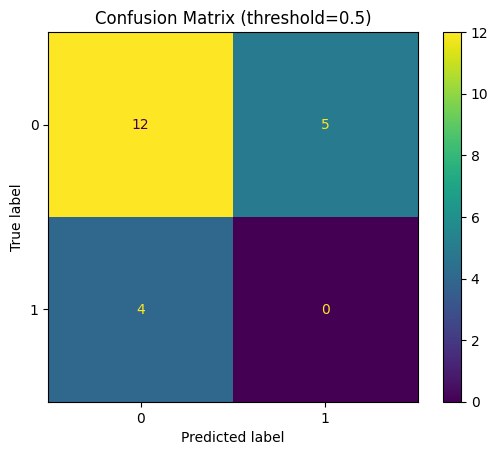

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Pick a threshold (0.5, or your tuned one)
thr = 0.5
y_pred = (y_score >= thr).astype(np.int64)

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion matrix (counts):\n", cm)

# Normalized per true class (i.e., recall per class)
cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
print("Confusion matrix (normalized by true class):\n", cm_norm)

# Quick report (precision/recall/F1 per class)
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

# Optional: plot (if you’re in a notebook)
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format='d')
plt.title(f'Confusion Matrix (threshold={thr})')
plt.show()

In [23]:
# flatten lists of tensors -> 1D numpy arrays


# pick a threshold (use 0.5 or your tuned threshold)
thr = 0.5
y_pred = (y_score >= thr).astype(np.int64)

# optional: nice class names
target_names = ["Negative (0)", "Positive (1)"]

print("Classification report @ threshold =", thr)
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

Classification report @ threshold = 0.5
              precision    recall  f1-score   support

Negative (0)     0.7778    0.4118    0.5385        17
Positive (1)     0.1667    0.5000    0.2500         4

    accuracy                         0.4286        21
   macro avg     0.4722    0.4559    0.3942        21
weighted avg     0.6614    0.4286    0.4835        21



In [24]:
from sklearn.metrics import precision_recall_curve
prec, rec, thr_list = precision_recall_curve(y_true, y_score)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = 0.5 if best_idx == len(thr_list) else thr_list[best_idx]

y_pred_best = (y_score >= best_thr).astype(np.int64)

print(f"\nClassification report @ best F1 threshold = {best_thr:.3f}")
print(classification_report(y_true, y_pred_best, target_names=target_names, digits=4))


Classification report @ best F1 threshold = 0.598
              precision    recall  f1-score   support

Negative (0)     0.8824    0.8824    0.8824        17
Positive (1)     0.5000    0.5000    0.5000         4

    accuracy                         0.8095        21
   macro avg     0.6912    0.6912    0.6912        21
weighted avg     0.8095    0.8095    0.8095        21



In [25]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
DiagnosisModel                           --
├─LSTMStack: 1-1                         --
│    └─LSTM: 2-1                         40,176
├─CNNExtractor: 1-2                      --
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  4,216
│    │    └─BatchNorm1d: 3-2             68
│    │    └─ReLU: 3-3                    --
│    │    └─Conv1d: 3-4                  3,502
│    │    └─BatchNorm1d: 3-5             68
│    │    └─ReLU: 3-6                    --
│    │    └─Dropout: 3-7                 --
│    └─AdaptiveAvgPool1d: 2-3            --
├─Sequential: 1-3                        --
│    └─Linear: 2-4                       7,424
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       1,040
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       34
Total params: 56,528
Trainable params: 56,528
Non-trainable params: 0